In [1]:
!pip install pydicom
!pip install pylidc

     |████████████████████████████████| 2.0 MB 7.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 62.3 MB/s eta 0:00:01
     |████████████████████████████████| 30.2 MB 57.2 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 65.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 61.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 58.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 71.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 82.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 96.2 MB/s eta 0:00:01
     |████████████████████████████████| 171 kB 69.0 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 68.8 MB/s eta 0:00:01


In [ ]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
pl.query(pl.Scan).count()
pid = 'LIDC-IDRI-0069'#'LIDC-IDRI-0001'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
scan.study_instance_uid

In [ ]:
import os
data_folder = os.getcwd() + '/cohort_sorted_3/'
data_folder

In [ ]:
#f = open ('.pylidcrc','w')            #For GCP
f = open ('/root/.pylidcrc','w')    #For Colab
f.write('[dicom]'+'\n')
f.write('path =' + data_folder +'\n')
f.write('warn = True')
f.close()

In [ ]:
myProjectID = "idc-external-012"

In [6]:
!pip install google-cloud-bigquery
!pip install --upgrade google-auth-oauthlib
!pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'

In [7]:
from google_auth_oauthlib import flow

# TODO: Uncomment the line below to set the `launch_browser` variable.
launch_browser = False
#
# The `launch_browser` boolean variable indicates if a local server is used
# as the callback URL in the auth flow. A value of `True` is recommended,
# but a local server does not work if accessing the application remotely,
# such as over SSH or from a remote Jupyter notebook.

appflow = flow.InstalledAppFlow.from_client_secrets_file(
    "client_secret_desktop.json", scopes=["https://www.googleapis.com/auth/bigquery"]
)

if launch_browser:
    appflow.run_local_server()
else:
    appflow.run_console()

credentials = appflow.credentials

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=354066013909-il5lh54dbass54iv45m7thff0uuefjar.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=OWwyiRzOYw3Q7lYge1jetQkNJaE9E9&prompt=consent&access_type=offline


Enter the authorization code:  4/1AX4XfWgxPWztkfFiOeZEfvSpcuMEb2KchUZvkX_TC9DLf5VbeAmZAZLNo-Q


In [8]:
%load_ext google.cloud.bigquery

In [9]:
from google.cloud.bigquery import magics
magics.context.credentials = credentials

In [10]:
%%bigquery CT_series --project=$myProjectID 

WITH
  all_lidc_ct_series AS (
  SELECT
    DISTINCT(SeriesInstanceUID),
    StudyInstanceUID,  
    PatientID,
    SliceThickness,
    ARRAY_TO_STRING(PixelSpacing,"/") as pixelspa 
  FROM
    `canceridc-data.idc_views.dicom_all`
  WHERE
    Modality = "CT"
    AND collection_id = "lidc_idri")
SELECT PatientID,SliceThickness,pixelspa,StudyInstanceUID,SeriesInstanceUID FROM
  all_lidc_ct_series
ORDER BY
  PatientID

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1018/1018 [00:01<00:00, 931.22rows/s]


In [11]:
import pandas as pd
s_1,s_2,s_3 = 5,5,5
ct_series_1 = CT_series[CT_series["SliceThickness"].astype(float)==1.0]
ct_series_2 = CT_series[CT_series["SliceThickness"].astype(float)==2.0]
ct_series_3 = CT_series[CT_series["SliceThickness"].astype(float)==3.0]
ct_series_HR = pd.concat([ct_series_1[:s_1],ct_series_2[:s_2],ct_series_3[:s_3]])

In [12]:
to_download = []
base_gs_uri = 'gs://idc-tcia-lidc-idri/dicom/'

for i in range(ct_series_HR.shape[0]):
    to_download.append(base_gs_uri + ct_series_HR.iloc[i]['StudyInstanceUID'] + '/' + ct_series_HR.iloc[i]['SeriesInstanceUID'])

manifest_df = pd.DataFrame({"gcs":to_download},columns=["gcs"])

In [13]:
manifest_df.to_csv("gcs_paths_small.txt",header=False, index=False)
!head gcs_paths_small.txt

gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.135045503670480596826162811572/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.165017330457520545748655969705/1.3.6.1.4.1.14519.5.2.1.6279.6001.324290109423920971676288828329
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.265704884949271879044145982159/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.815399168774050638734383723372/1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.311849240521371267537044867782/1.3.6.1.4.1.14519.5.2.1.6279.6001.387954549120924524005910602207
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.303241414168367763244410429787/1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905446238286154504249
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.

In [18]:
!pip install gsutil

     |████████████████████████████████| 2.9 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 14.5 MB/s eta 0:00:01
     |████████████████████████████████| 135 kB 89.1 MB/s eta 0:00:01
     |████████████████████████████████| 95 kB 7.5 MB/s  eta 0:00:01
     |████████████████████████████████| 55 kB 6.2 MB/s  eta 0:00:01
     |████████████████████████████████| 1.4 MB 53.0 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 13.6 MB/s  eta 0:00:01
     |████████████████████████████████| 3.5 MB 60.6 MB/s eta 0:00:01
  Created wheel for gsutil: filename=gsutil-5.3-py3-none-any.whl size=3713522 sha256=45a398449f32a24d6960ec4f889aa1d338edb66e4659187210e8023ea112ea60
  Stored in directory: /root/.cache/pip/wheels/b2/4a/2c/1b8db4719f842155e5b945c0a76af939519c6d6d5da7fc4019
  Created wheel for crcmod: filename=crcmod-1.7-cp38-cp38-linux_x86_64.whl size=36034 sha256=1da164711e97585e884fd2aceaa4c72df7a845012e3dd804f0eab2c8917b2734
  Stored in directory: /root/.cache/p

In [14]:
!mkdir /data/downloaded_small_lidc
!cat gcs_paths_small.txt | gsutil -u $myProjectID -m cp -Ir /data/downloaded_small_lidc

Copying gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.135045503670480596826162811572/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288/1.3.6.1.4.1.14519.5.2.1.6279.6001.105861434427579961871622921162.dcm...
Copying gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.135045503670480596826162811572/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288/1.3.6.1.4.1.14519.5.2.1.6279.6001.100191094280203283283021962486.dcm...
Copying gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.135045503670480596826162811572/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288/1.3.6.1.4.1.14519.5.2.1.6279.6001.107636363556902923282622183214.dcm...
Copying gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.135045503670480596826162811572/1.3.6.1.4.1.14519.5.2.1.6279.6001.326057189095429101398977448288/1.3.6.1.4.1.14519.5.2.1.6279.6001.109860399995585698678237944131.dcm...
Copying gs://idc-tcia-lidc-idri/dicom/1.

In [15]:
!python dicomsort/dicomsort.py -u /data/downloaded_small_lidc /data/downloaded_small_lidc_sorted/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm

100%|██████████████████████████████████████| 3448/3448 [00:06<00:00, 550.03it/s]
Files sorted


In [7]:
data_folder = '/data/downloaded_small_lidc_sorted/'
f = open ('.pylidcrc','w')            #For GCP
# f = open ('/root/.pylidcrc','w')    #For Colab
f.write('[dicom]'+'\n')
f.write('path =' + data_folder +'\n')
f.write('warn = True')
f.close()

Current patient ID = LIDC-IDRI-0086
Loading dicom files ... This may take a moment.


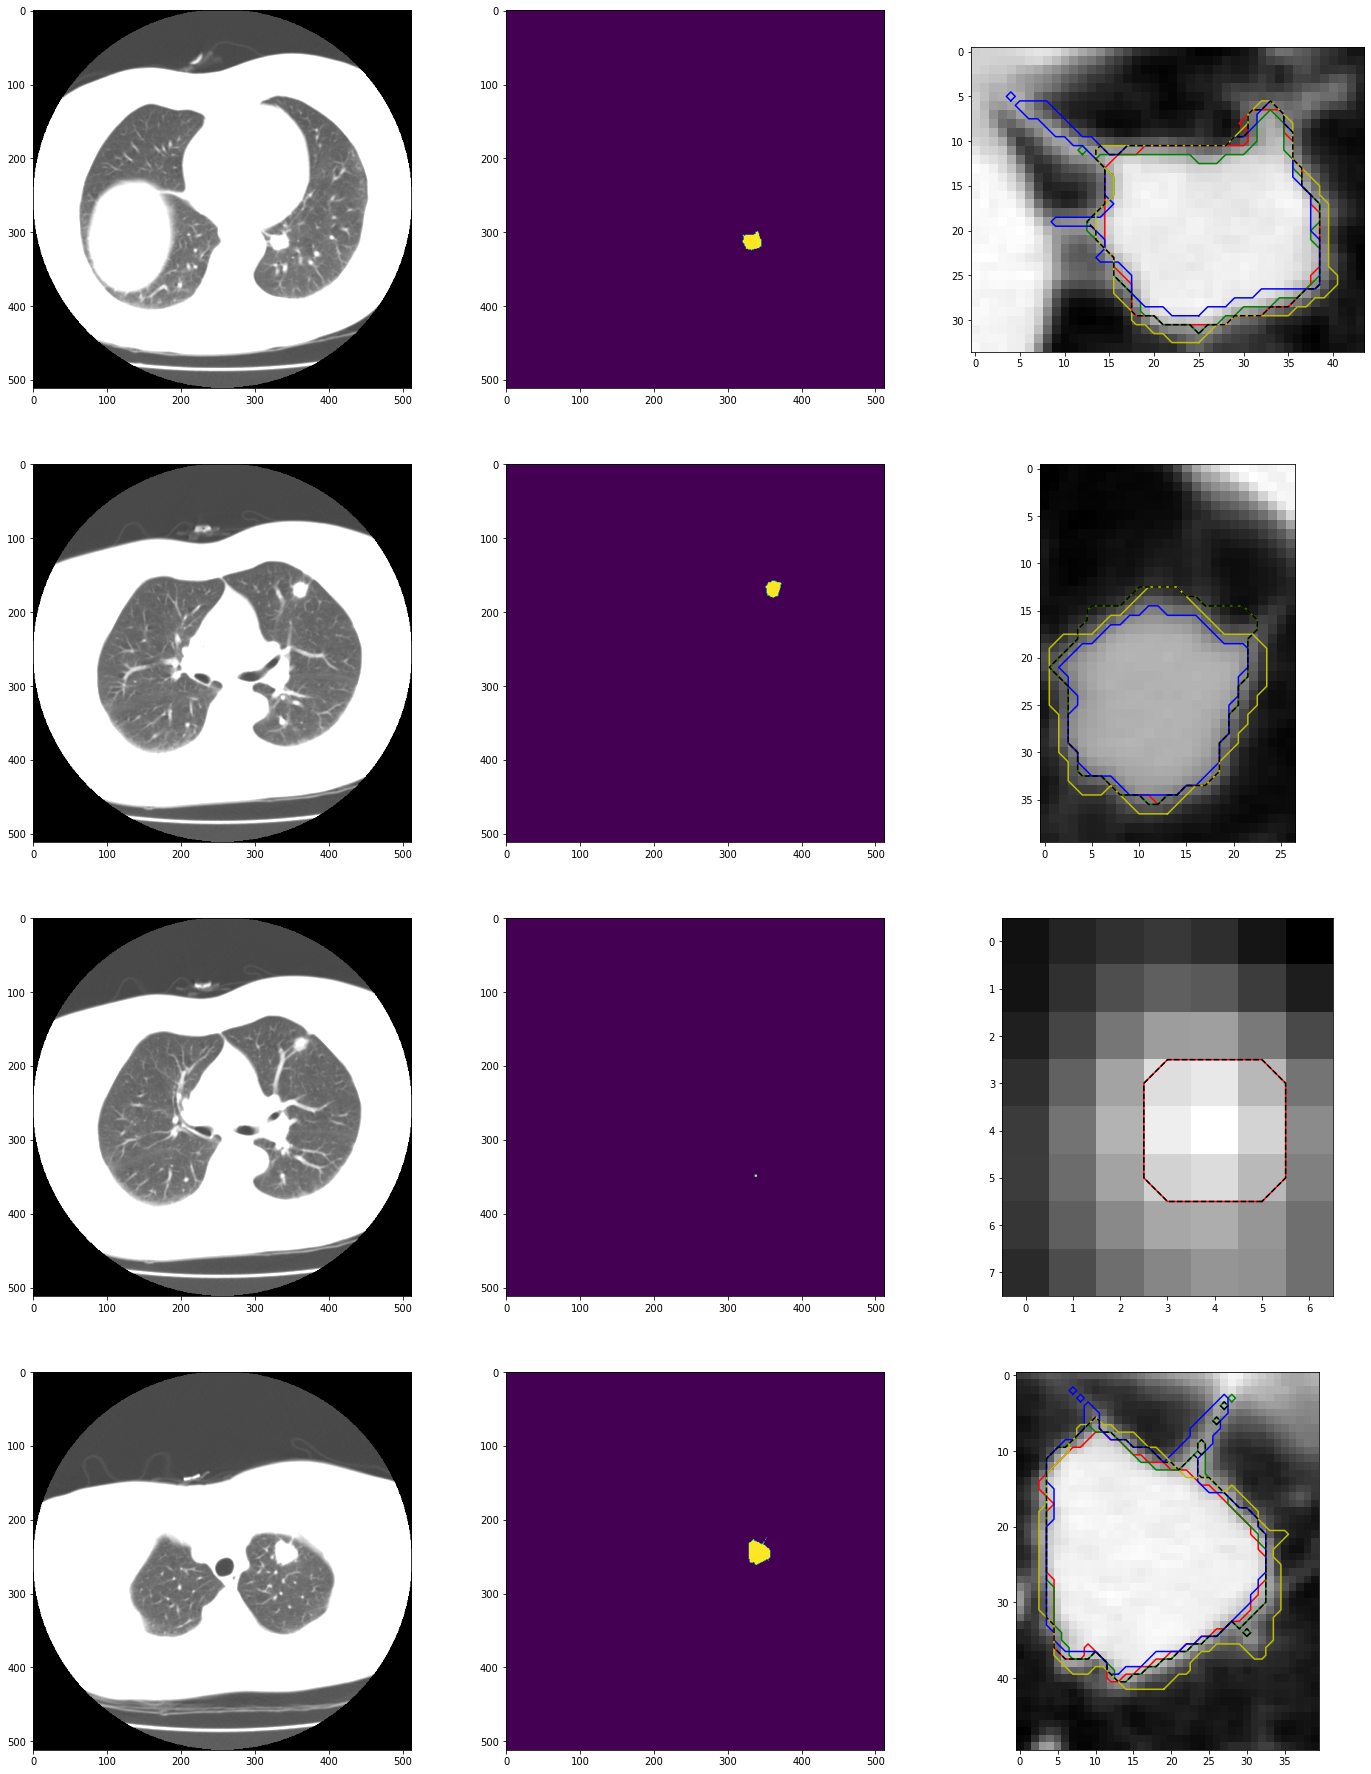

In [8]:
%matplotlib inline

cohort = data_folder
patient_list = os.listdir(cohort)
patient_select = 0

print ("Current patient ID =", patient_list[patient_select])

scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    plt.subplot(nodule_num,3,1+i*3)
    plt.imshow(vol[:,:,k_slice],cmap='gray')
    plt.clim(vmin=-1350,vmax=-150)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])

    plt.subplot(nodule_num,3,3+i*3)
    plt.imshow(vol[cbbox][:,:,k],cmap='gray')
    # Plot the annotation contours for the kth slice.
    colors = ['r', 'g', 'b', 'y']
    for j in range(len(masks)):
        for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
            label = "Annotation %d" % (j+1)
            plt.plot(c[:,1], c[:,0], colors[j], label=label)

    # Plot the 50% consensus contour for the kth slice.
    for c in find_contours(cmask[:,:,k].astype(float), 0.5):
        plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

In [9]:
#

In [13]:
CT_image_data = []
CT_mask_data  = []

for pa in range(len(patient_list)):
    print ("Current patient ID =", patient_list[pa])
    
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
    nodules_annotation = scan[pa].cluster_annotations()
    vol = scan[pa].to_volume()
    
    CT_image_data.append(vol)
    
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)   

    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]    
        CT_mask[cbbox] += cmask
        
    CT_mask_data.append(CT_mask)

Current patient ID = LIDC-IDRI-0086
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0095
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0298
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0101
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0300
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0106
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0314
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0094
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0325
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0069
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0098
Loading dicom files ... This may take a moment.
Current patient ID = LIDC-IDRI-0084
Loading dicom files ... This may take a 

In [14]:
from numpy import random
os.makedirs('/data/small/train')
os.mkdir('/data/small/train/image')
os.mkdir('/data/small/train/mask')
os.mkdir('/data/small/val')
os.mkdir('/data/small/val/image')
os.mkdir('/data/small/val/mask')

FileExistsError: [Errno 17] File exists: '/data/small/train'

In [16]:
train_image_root = '/data/small/train/image/'
train_mask_root  = '/data/small/train/mask/'
val_image_root   = '/data/small/val/image/'
val_mask_root    = '/data/small/val/mask/'


In [72]:
# from numpy import random
# os.makedirs('/data/small/train')
# os.mkdir('/data/small/train/image')
# os.mkdir('/data/small/train/mask')
# os.mkdir('/data/small/val')
# os.mkdir('/data/small/val/image')
# os.mkdir('/data/small/val/mask')


val_ratio = 0.2
SEED = 1
random.seed(SEED)
file_list = [i for i in range(len(patient_list))]
random.shuffle(file_list)
train_list = file_list[:int(len(patient_list)*(1-val_ratio))]
val_list = file_list[int(len(patient_list)*(1-val_ratio)):]

for i in train_list:
    for j in range(CT_image_data[i].shape[2]):
        image_npfile = train_image_root+str(i)+'-'+str(j)+'.npy'
        mask_npfile  = train_mask_root+str(i)+'-'+str(j)+'.npy'
        np.save(image_npfile, CT_image_data[i][:,:,j][:,:, np.newaxis])
        np.save(mask_npfile, CT_mask_data[i][:,:,j][:,:, np.newaxis])
        
for i in val_list:
    for j in range(CT_image_data[i].shape[2]):
        image_npfile = val_image_root+str(i)+'-'+str(j)+'.npy'
        mask_npfile  = val_mask_root+str(i)+'-'+str(j)+'.npy'
        np.save(image_npfile, CT_image_data[i][:,:,j][:,:, np.newaxis])
        np.save(mask_npfile, CT_mask_data[i][:,:,j][:,:, np.newaxis])   
        
# train_files = os.listdir(train_image_root)
# val_files   = os.listdir(val_image_root)
# train_image_paths = [train_image_root + path for path in train_files]
# train_mask_paths  = [train_mask_root + path for path in train_files]
# val_image_paths   = [val_image_root + path for path in val_files]
# val_mask_paths    = [val_mask_root + path for path in val_files]
# print(len(train_image_paths),len(train_mask_paths))
# print(len(val_image_paths),len(val_mask_paths))

In [17]:
train_files = os.listdir(train_image_root)
val_files   = os.listdir(val_image_root)
train_image_paths = [train_image_root + path for path in train_files]
train_mask_paths  = [train_mask_root + path for path in train_files]
val_image_paths   = [val_image_root + path for path in val_files]
val_mask_paths    = [val_mask_root + path for path in val_files]
print(len(train_image_paths),len(train_mask_paths))
print(len(val_image_paths),len(val_mask_paths))

2544 2544
904 904


In [18]:
[(i, m) for i, m in zip(train_image_paths, train_mask_paths)][:5]

[('/data/small/train/image/9-96.npy', '/data/small/train/mask/9-96.npy'),
 ('/data/small/train/image/9-48.npy', '/data/small/train/mask/9-48.npy'),
 ('/data/small/train/image/10-216.npy', '/data/small/train/mask/10-216.npy'),
 ('/data/small/train/image/6-144.npy', '/data/small/train/mask/6-144.npy'),
 ('/data/small/train/image/6-200.npy', '/data/small/train/mask/6-200.npy')]

In [19]:
np.load('/data/small/train/mask/9-96.npy').shape

(512, 512, 1)

#### Data loader

In [11]:
import tensorflow as tf

2021-10-02 06:30:27.675063: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


In [98]:
def train_data_generator(image_path, mask_path):
    for img_path, msk_path in zip(image_path, mask_path):
    #for i in range(len(image_path)):
        image = np.load(img_path).astype('float32')#['arr_0']
        mask = np.load(msk_path).astype('float32')#['arr_0']
        image -= np.mean(image)
        image /= np.std(image)
        
        yield image, tf.keras.utils.to_categorical(mask, num_classes=2)

def get_train_dataset_from_directory(image_path, mask_path):
    generator = lambda: train_data_generator(image_path, mask_path)
    return tf.data.Dataset.from_generator(
        generator, output_signature=(
            tf.TensorSpec(shape=(512, 512, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(512, 512, 2), dtype=tf.float32)))

In [99]:
# image_path = '/data/small/train/images'
# mask_path = '/data/small/train/masks'
# image_files = os.listdir(image_path)
ds_train = get_train_dataset_from_directory(train_image_paths, train_mask_paths)

In [100]:
ds_train.element_spec

(TensorSpec(shape=(512, 512, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(512, 512, 2), dtype=tf.float32, name=None))

In [101]:
# image_path = '/data/small/val/images'
# mask_path = '/data/small/val/masks'
# image_files = os.listdir(image_path)
ds_val = get_train_dataset_from_directory(val_image_paths, val_mask_paths)

In [102]:
for a, b in ds_train.take(1):
    print(a.shape)

(512, 512, 1)


In [103]:
for a, b in ds_val.take(1):
    print(a.shape)

(512, 512, 1)


In [104]:
b

<tf.Tensor: shape=(512, 512, 2), dtype=float32, numpy=
array([[[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       ...,

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]], dtype=float32)>

### The model

In [26]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np

In [222]:
img_size = (512, 512)
num_classes = 2
batch_size = 12

In [263]:

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

mirrored_strategy = tf.distribute.MirroredStrategy()
# Build model
with mirrored_strategy.scope():
    model = get_model(img_size, num_classes)
#model = get_model(img_size, num_classes)
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [264]:
from keras import backend as K
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    return tf.reduce_mean( (2. * intersection + smooth) / (union + smooth), axis=0)

# def mean_iou(y_true, y_pred):
#     y_true = tf.cast(y_true, tf.dtypes.float64)
#     y_pred = tf.cast(y_pred, tf.dtypes.float64)
#     I = tf.reduce_sum(y_pred * y_true, axis=(1, 2))
#     U = tf.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
#     return tf.reduce_mean(I / U)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=[dice_coef, iou_coef])

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

In [234]:
ds_train.element_spec

(TensorSpec(shape=(512, 512, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(512, 512, 2), dtype=tf.float32, name=None))

In [235]:
dataset_train = ds_train.shuffle(320).batch(batch_size)
dataset_val = ds_val.shuffle(320).batch(batch_size)

In [265]:
# Train the model, doing validation at the end of each epoch.
epochs = 25
history = model.fit(dataset_train, epochs=epochs, validation_data=dataset_val, callbacks=callbacks)

2021-10-02 08:11:08.965951: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_15437"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 512
        }
        dim {
          size: 512
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 512
        }
        dim {
          size: 512
        }
        dim {
          size: 2
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
   

Epoch 1/25
INFO:tensorflow:batch_all_reduce: 82 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 82 all-reduces with algorithm = nccl, num_packs = 1


2021-10-02 08:11:25.103678: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202


     33/Unknown - 34s 455ms/step - loss: 0.1401 - dice_coef: 0.9790 - iou_coef: 0.9738

KeyboardInterrupt: 

In [254]:
for sample_input, sample_target in ds_train.take(1):
    break;

In [148]:
sample_input = tf.expand_dims(sample_input, 0)

In [179]:
sample_pred = model(sample_input)

In [181]:
pred_mask = np.argmax(sample_pred[0], axis=-1)

In [202]:
pred_mask = np.int64(pred_mask)

In [184]:
#sample_target[0]
true_mask = np.argmax(sample_target[0], axis=-1)

In [216]:
true_mask = np.int64(true_mask)

In [217]:
true_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [218]:
pred_mask = tf.convert_to_tensor(
    pred_mask, dtype=tf.int64, dtype_hint=None, name=None
)
true_mask = tf.convert_to_tensor(
    true_mask, dtype=tf.int64, dtype_hint=None, name=None
)

In [219]:
pred_mask

<tf.Tensor: shape=(512, 512), dtype=int64, numpy=
array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 0]])>

In [220]:
scce = tf.keras.losses.CategoricalCrossentropy()
#pred = sample_pred[0].numpy()
scce(true_mask, pred_mask)

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a int64 tensor but is a double tensor [Op:Mul]

In [171]:
y_true = [1., 0.]
y_pred = [[0.05, 0.95], [0.2, 0.8]]
# Using 'auto'/'sum_over_batch_size' reduction type.
scce = tf.keras.losses.SparseCategoricalCrossentropy()
scce(y_true, y_pred).numpy()

0.83036566

Current patient ID = LIDC-IDRI-0086
Loading dicom files ... This may take a moment.


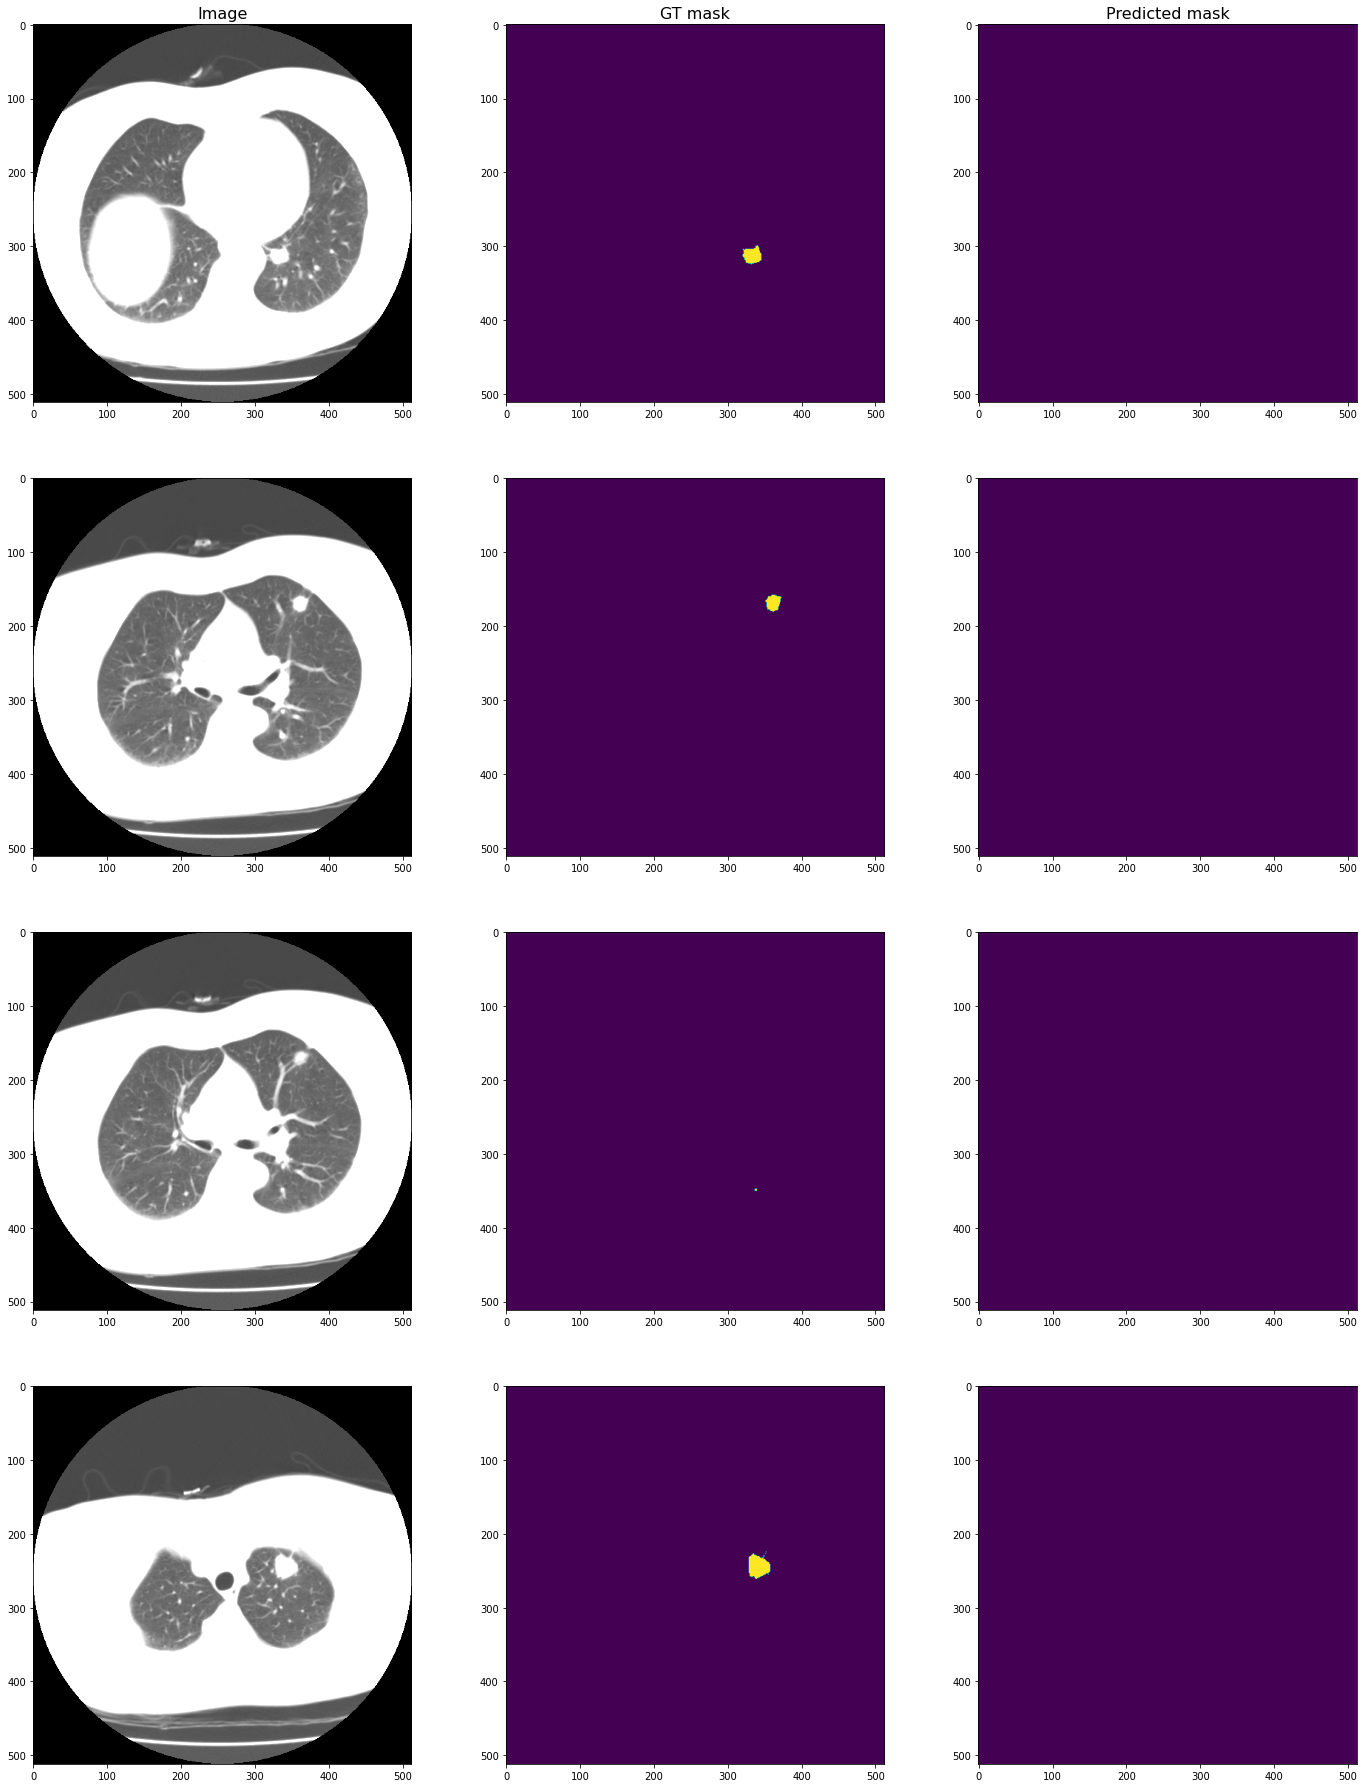

In [266]:
%matplotlib inline

cohort = data_folder
patient_list = os.listdir(cohort)
patient_select = 0

print ("Current patient ID =", patient_list[patient_select])

scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    plt.subplot(nodule_num,3,1+i*3)
    plt.imshow(vol[:,:,k_slice],cmap='gray')
    plt.clim(vmin=-1350,vmax=-150)
    if i==0:
        plt.title('Image',fontsize=16)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])
    if i==0:
        plt.title('GT mask',fontsize=16)

    plt.subplot(nodule_num,3,3+i*3)
    image = vol[:,:,k_slice].astype('float32')
    image -= np.mean(image)
    image /= np.std(image)
#     image = torch.from_numpy(image[np.newaxis,np.newaxis,:]).to(device)
#     mask_pre = torch.sigmoid(model(image)).detach().cpu().numpy()
    mask_pre = model(image[np.newaxis, :, :, np.newaxis])
    #mask_pre = torch.sigmoid(model(image)).detach().cpu().numpy()
    mask_pre = np.squeeze(mask_pre)
  #  print(np.max(mask_pre), np.min(mask_pre))
  #  print(np.max(CT_mask[:,:,k_slice]), np.min(CT_mask[:,:,k_slice]))
    #mask_pre = np.where(mask_pre>0.5, 1,0)
    #mask_pre = np.argmax(np.where(mask_pre > 0.5, 1, 0), axis = -1)
    mask_pre = np.argmax(np.where(mask_pre > 0.5, 1, 0), axis = -1)
    plt.imshow(mask_pre)
    if i==0:
        plt.title('Predicted mask',fontsize=16)

In [238]:
mask_pre = model(image[np.newaxis, :, :, np.newaxis])
#mask_pre = torch.sigmoid(model(image)).detach().cpu().numpy()
mask_pre = np.squeeze(mask_pre)

In [239]:
mask_pre.shape

(512, 512, 2)

In [241]:
mask_pre

array([[[9.9937528e-01, 6.2476884e-04],
        [9.9784398e-01, 2.1560388e-03],
        [9.9665713e-01, 3.3428767e-03],
        ...,
        [9.7657096e-01, 2.3429031e-02],
        [9.7840643e-01, 2.1593582e-02],
        [4.4759211e-01, 5.5240792e-01]],

       [[9.9977535e-01, 2.2463000e-04],
        [9.9999893e-01, 1.0652730e-06],
        [9.9999905e-01, 9.9981105e-07],
        ...,
        [9.9999571e-01, 4.2534134e-06],
        [9.9999785e-01, 2.1772723e-06],
        [9.9998343e-01, 1.6622436e-05]],

       [[9.9969721e-01, 3.0279497e-04],
        [9.9999726e-01, 2.7894396e-06],
        [9.9999762e-01, 2.4242386e-06],
        ...,
        [9.9999034e-01, 9.6519798e-06],
        [9.9999595e-01, 4.0669047e-06],
        [9.9998283e-01, 1.7198772e-05]],

       ...,

       [[9.9982774e-01, 1.7226431e-04],
        [9.9999714e-01, 2.8742854e-06],
        [9.9999475e-01, 5.2681362e-06],
        ...,
        [9.9998784e-01, 1.2176291e-05],
        [9.9999416e-01, 5.8826067e-06],
        [

In [247]:
np.argmax(np.where(mask_pre > 0.5, 1, 0), axis = -1)

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])